In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data (as pandas dataframes) 
X = soybean_large.data.features 
y = soybean_large.data.targets 

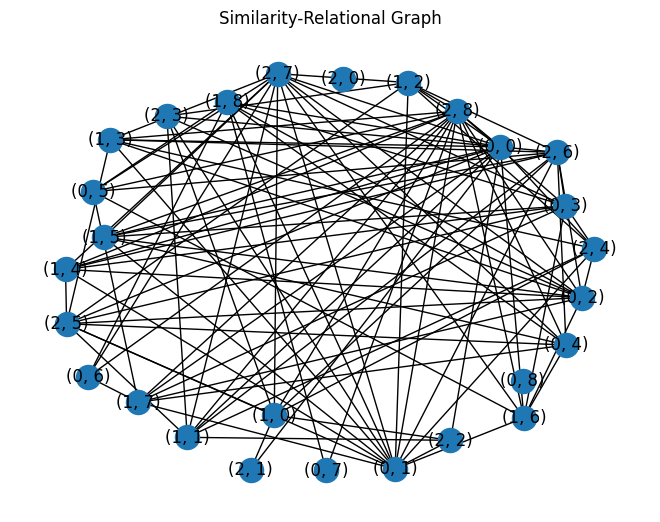

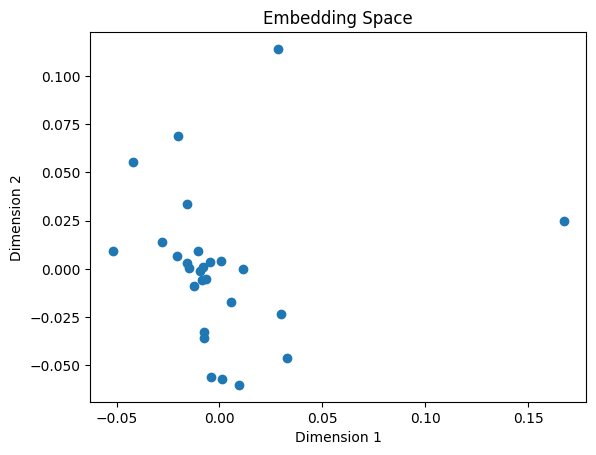

Embedding Matrix:
 [[-0.0048116   0.00369337]
 [-0.01581237  0.03387348]
 [ 0.16724991  0.02504127]
 [-0.01041377  0.00949856]
 [-0.01215915 -0.00881098]
 [-0.00386121 -0.05585447]
 [-0.02018519  0.06886043]
 [ 0.02867578  0.11398356]
 [ 0.02979694 -0.0235485 ]
 [-0.01574534  0.00287027]
 [-0.04215329  0.05533298]
 [ 0.00138133 -0.05703293]
 [ 0.03275604 -0.04599517]
 [-0.00747183 -0.03587708]
 [-0.0205682   0.00669389]
 [-0.00796441  0.00117394]
 [ 0.00928194 -0.06007661]
 [-0.00848604 -0.00547681]
 [ 0.00093713  0.00436895]
 [-0.009542   -0.00127442]
 [ 0.01162965 -0.00022764]
 [-0.05178792  0.0093493 ]
 [ 0.00582503 -0.01732963]
 [-0.00666579 -0.00505121]
 [-0.02770373  0.01371323]
 [-0.00753911 -0.03261734]
 [-0.01466281  0.00071954]]


In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
def construct_similarity_graph(X):
    """
    Construct a similarity-relational graph for categorical values in X.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
         
    Returns:
    - G: NetworkX graph
         Similarity-relational graph.
    """
    # Initialize an empty graph
    G = nx.Graph()
    
    # Perform one-hot encoding to convert categorical values to numerical
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X).toarray()
    
    # Compute pairwise cosine similarity between categorical values
    similarity_matrix = cosine_similarity(X_encoded)
    
    # Add nodes to the graph
    n_samples, n_features = X_encoded.shape
    for i in range(n_samples):
        for j in range(n_features):
            G.add_node((i, j))
    
    # Add edges to the graph based on cosine similarity
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            for k in range(n_features):
                for l in range(k+1, n_features):
                    sim = similarity_matrix[i, j]
                    G.add_edge((i, k), (j, l), weight=sim)
    
    return G

def graph_embedding(X, embedding_dim=2):
    """
    Perform graph embedding to learn the representation of nodes in the similarity-relational graph.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
    - embedding_dim: int, default=2
                     Dimensionality of the embedding space.
                     
    Returns:
    - embedding_matrix: array-like, shape (n_samples * n_features, embedding_dim)
                        Embedding matrix representing the nodes in the graph.
    """
    # Construct similarity-relational graph
    G = construct_similarity_graph(X)
    
    # Visualize the graph
    nx.draw(G, with_labels=True)
    plt.title('Similarity-Relational Graph')
    plt.show()
    
    # Perform spectral embedding to learn the representation of nodes
    spectral_embedding = SpectralEmbedding(n_components=embedding_dim)
    embedding_matrix = spectral_embedding.fit_transform(nx.adjacency_matrix(G))
    
    # Visualize the embedding space
    plt.scatter(embedding_matrix[:, 0], embedding_matrix[:, 1])
    plt.title('Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    
    return embedding_matrix

# Example usage
# Assuming X is your categorical data matrix
X = np.array([
    ['A', 'B', 'C'],
    ['D', 'E', 'F'],
    ['G', 'H', 'I']
])

# Perform graph embedding
embedding_matrix = graph_embedding(X)
print("Embedding Matrix:\n", embedding_matrix)

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
import pandas as pd
from sklearn.impute import SimpleImputer

# Data 
X = soybean_large.data.features 
y = soybean_large.data.targets 

# One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# Function to perform clustering and calculate performance indices
def evaluate_clustering(X, y_true, method='kmeans'):
    if method == 'kmeans':
        clustering = KMeans(n_clusters=len(np.unique(y_true))).fit(X)
    elif method == 'hierarchical':
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(y_true))).fit(X)
    else:
        raise ValueError("Invalid clustering method. Use 'kmeans' or 'hierarchical'.")
    
    y_pred = clustering.labels_
    ari = adjusted_rand_score(y_true.values.ravel(), y_pred)
    nmi = normalized_mutual_info_score(y_true.values.ravel(), y_pred)
    fmi = fowlkes_mallows_score(y_true.values.ravel(), y_pred)

    
    return ari, nmi, fmi

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X_encoded)

# Perform clustering and evaluate with different methods
ari_kmeans, nmi_kmeans, fmi_kmeans = evaluate_clustering(X_imputed, y, method='kmeans')
ari_hierarchical, nmi_hierarchical, fmi_hierarchical = evaluate_clustering(X_imputed, y, method='hierarchical')

# Print the results
print("KMeans:")
print("Adjusted Rand Index (ARI):", ari_kmeans)
print("Normalized Mutual Information (NMI):", nmi_kmeans)
print("Folkes-Mallows Index (FMI):", fmi_kmeans)

print("\nHierarchical Clustering:")
print("Adjusted Rand Index (ARI):", ari_hierarchical)
print("Normalized Mutual Information (NMI):", nmi_hierarchical)
print("Folkes-Mallows Index (FMI):", fmi_hierarchical)

KMeans:
Adjusted Rand Index (ARI): 0.40005134051944224
Normalized Mutual Information (NMI): 0.6827835321332222
Folkes-Mallows Index (FMI): 0.4476934853652196

Hierarchical Clustering:
Adjusted Rand Index (ARI): 0.4818572638479213
Normalized Mutual Information (NMI): 0.7714741801659014
Folkes-Mallows Index (FMI): 0.5238794514629941


**Adjusted Rand Index (ARI):**

**Advantages:**
- ARI measures the similarity between two clustering results, considering all pairs of samples and their memberships in the clusters.
- It adjusts for chance, providing a baseline for random clustering by comparing the expected similarity of randomly clustered data with the actual clustering.
- ARI ranges from -1 to 1, where 1 indicates perfect similarity between two clusterings.

**Disadvantages:**
- ARI does not consider the true labels of the data directly, making it sensitive to the number of clusters and their sizes.
- It is not normalized and can take negative values, which can complicate interpretation.

**When to use:**
- ARI is useful when ground truth labels are available and you want to evaluate the similarity between the predicted clusters and the true labels.
- It is commonly used for evaluating clustering algorithms in scenarios where the ground truth is available.

**Normalized Mutual Information (NMI):**

**Advantages:**
- NMI measures the mutual dependence between the true labels and the predicted clusters, adjusting for chance.
- It is normalized, always falling between 0 and 1, with 1 indicating perfect agreement between the clustering and the true labels.
- NMI is symmetric, meaning it does not depend on the order of the true labels or the predicted clusters.

**Disadvantages:**
- NMI can be biased towards clusters with more homogeneous sizes, as it does not penalize for over-fragmentation or under-fragmentation.

**When to use:**
- NMI is suitable when you want to evaluate the overall agreement between the true labels and the predicted clusters, irrespective of the number of clusters or their sizes.
- It is commonly used in situations where the ground truth is available but the number of clusters may vary.

**Folkes-Mallows Index (FMI):**

**Advantages:**
- FMI measures the geometric mean of precision and recall of the clustering with respect to the true classes.
- It provides a balanced evaluation of both precision and recall, considering both false positives and false negatives.

**Disadvantages:**
- FMI may not be as widely used or as well-known as ARI or NMI.

**When to use:**
- FMI is useful when you want a balanced evaluation of both precision and recall in clustering.
- It is particularly relevant when false positives and false negatives have different implications or costs in your application domain.


In [4]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.impute import SimpleImputer

# Define a function to evaluate clustering performance
def evaluate_clustering(X, y_true, method='kmodes'):
    if method == 'kmodes':
        clustering = KModes(n_clusters=len(np.unique(y_true)), init='Cao', n_init=5, verbose=0)
    elif method == 'hierarchical':
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(y_true)))
    else:
        raise ValueError("Invalid clustering method. Use 'kmodes' or 'hierarchical'.")
    
    y_pred = clustering.fit_predict(X)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    fmi = fowlkes_mallows_score(y_true, y_pred)
    
    return ari, nmi, fmi

# Load your dataset and preprocess if needed
# Assuming you have your dataset loaded into X and y variables

# Preprocess the dataset
def preprocess_data(X):
    # One-hot encode categorical features if needed
    X_encoded = pd.get_dummies(X)
    # Impute missing values if needed
    imputer = SimpleImputer(strategy='most_frequent')
    X_imputed = imputer.fit_transform(X_encoded)
    return X_imputed

# Convert y to a 1-dimensional pandas Series
y_series = y.squeeze()

# Preprocess the data
X_imputed = preprocess_data(X)

# Perform clustering and evaluate with different methods
clustering_methods = ['kmodes', 'hierarchical']
results = {}

for method in clustering_methods:
    results[method] = evaluate_clustering(X_imputed, y_series, method=method)

# Print the results
for method in clustering_methods:
    ari, nmi, fmi = results[method]
    print(f"{method.capitalize()} Clustering:")
    print(f"Adjusted Rand Index (ARI): {ari}")
    print(f"Normalized Mutual Information (NMI): {nmi}")
    print(f"Folkes-Mallows Index (FMI): {fmi}\n")


Kmodes Clustering:
Adjusted Rand Index (ARI): 0.36748616012340063
Normalized Mutual Information (NMI): 0.6915333229576721
Folkes-Mallows Index (FMI): 0.42485959928639194

Hierarchical Clustering:
Adjusted Rand Index (ARI): 0.4818572638479213
Normalized Mutual Information (NMI): 0.7714741801659014
Folkes-Mallows Index (FMI): 0.5238794514629941



**Report**

Clustering, a key component of unsupervised learning, involves grouping similar data points based on shared characteristics or attributes. Evaluating the performance of clustering algorithms is essential to determine their effectiveness in categorizing data meaningfully. Various performance metrics are used for this purpose, each with its own advantages and disadvantages. In this report, we will examine three widely used metrics for clustering performance: the Folkes-Mallows Index (FMI), the Normalized Mutual Information (NMI), and the Adjusted Rand Index (ARI). We will discuss the rationale behind each metric, its benefits, drawbacks, and appropriate applications.

**Adjusted Rand Index (ARI)**:
The Adjusted Rand Index (ARI) measures the similarity between two clustering results, considering all pairs of samples and their cluster memberships. It adjusts for chance, comparing the expected similarity of randomly clustered data with the actual clustering.

**Advantages**:
- ARI provides a quantitative measure of agreement between two clustering results, ranging from -1 to 1, where 1 indicates perfect similarity.
- It is useful when ground truth labels are available for evaluation, commonly used in scenarios where the true clustering is known.

**Disadvantages**:
- ARI does not directly consider the true labels of the data, making it sensitive to the number of clusters and their sizes.
- It is not normalized and can take negative values, making interpretation challenging.

**Normalized Mutual Information (NMI)**:
Normalized Mutual Information (NMI) measures the mutual dependence between the true labels and the predicted clusters, adjusting for chance. It provides a normalized measure of agreement between two clustering results, always falling between 0 and 1, with 1 indicating perfect agreement.

**Advantages**:
- NMI offers a normalized measure of agreement, making it easier to interpret compared to ARI.
- It is symmetric, meaning it does not depend on the order of the true labels or the predicted clusters.

**Disadvantages**:
- NMI can be biased towards clusters with more homogeneous sizes, as it does not penalize for over-fragmentation or under-fragmentation.

**Folkes-Mallows Index (FMI)**:
The Folkes-Mallows Index (FMI) measures the geometric mean of precision and recall of the clustering with respect to the true classes. It provides a balanced evaluation of both precision and recall, taking into account both false positives and false negatives.

**Advantages**:
- FMI offers a balanced evaluation of precision and recall in clustering, making it suitable for assessing the quality of clustering results.
- It provides insights into both false positives and false negatives, offering a comprehensive view of clustering performance.

**Disadvantages**:
- FMI may not be as widely used or as well-known as ARI or NMI, leading to less familiarity among practitioners.

**Conclusion**

In conclusion, each clustering performance metric has unique strengths and weaknesses. ARI is useful for evaluating clustering methods when ground truth labels are available, but its performance can be affected by the number and size of clusters. NMI provides a normalized measure of agreement between true labels and predicted clusters, though it may favor clusters with more uniform sizes. FMI offers a balanced evaluation of precision and recall in clustering, providing insights into both false positives and false negatives. Understanding the characteristics of each metric is essential to select the most appropriate one based on the specific requirements of the clustering task.
